# Machine Learning Hackathon

Your client is a multi-national financial company, which offers multiple products to the consumers. There are multiple channels to offer these products to consumers although major contribution is coming from offline distribution channel. Offline channel sells Financial products to consumers via their agent network and as per government regulation these agents must be certified to sell financial products. There are multiple certification programs against different categories of financial products. 

As this offline channel shares major contribution to total company sales, company focuses on recruitment and certify them to build large agent network. Here, major challenge is training them to get the certifications to sell various type of products.

You are given a dataset of trainee performance for the training curriculum test wise within multiple programs. Your task is to predict the performance on such tests given the demographic information and training program/test details. This will enable your client to strengthen its training problem by figuring out the most important factors that lead to a better engagement and performance for a trainee.

Evaluation Metric
The evaluation metric for this competition is AUC ROC score.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce  
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
#from pycaret.classification import *
%matplotlib inline

In [12]:
train_df = pd.read_csv('train_HK6lq50.csv')
test_df = pd.read_csv('test_wF0Ps6O.csv')
print (train_df.shape,test_df.shape)

(73147, 16) (31349, 15)


In [13]:
train_df.dtypes

id                            object
program_id                    object
program_type                  object
program_duration               int64
test_id                        int64
test_type                     object
difficulty_level              object
trainee_id                     int64
gender                        object
education                     object
city_tier                      int64
age                          float64
total_programs_enrolled        int64
is_handicapped                object
trainee_engagement_rating    float64
is_pass                        int64
dtype: object

Proportion: 0.44 : 1


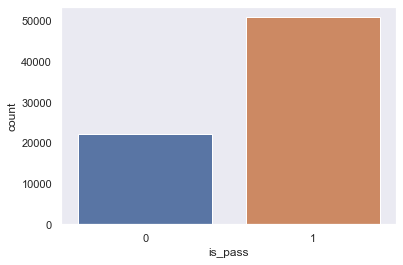

In [14]:
target_count = (train_df['is_pass']).value_counts()
sns.countplot(train_df['is_pass'])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

In [15]:
train_df.head()

,id,program_id,program_type,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,is_pass
0,9389_150,Y_1,Y,136,150,offline,intermediate,9389,M,Matriculation,3,24.0,5,N,1.0,0
1,16523_44,T_1,T,131,44,offline,easy,16523,F,High School Diploma,4,26.0,2,N,3.0,1
2,13987_178,Z_2,Z,120,178,online,easy,13987,M,Matriculation,1,40.0,1,N,2.0,1
3,13158_32,T_2,T,117,32,offline,easy,13158,F,Matriculation,3,NaN,4,N,1.0,1
4,10591_84,V_3,V,131,84,offline,intermediate,10591,F,High School Diploma,1,42.0,2,N,4.0,1


In [16]:
test_df.isna().sum()

id                               0
program_id                       0
program_type                     0
program_duration                 0
test_id                          0
test_type                        0
difficulty_level                 0
trainee_id                       0
gender                           0
education                        0
city_tier                        0
age                          11791
total_programs_enrolled          0
is_handicapped                   0
trainee_engagement_rating       31
dtype: int64

In [17]:
# Addressing missing values
train_df['age'].fillna((train_df['age'].median()),inplace=True)
train_df['trainee_engagement_rating'].fillna((train_df['trainee_engagement_rating'].mean()),inplace=True)
test_df['age'].fillna((test_df['age'].median()),inplace=True)
test_df['trainee_engagement_rating'].fillna((test_df['trainee_engagement_rating'].mean()),inplace=True)
train_df.head()

,id,program_id,program_type,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,is_pass
0,9389_150,Y_1,Y,136,150,offline,intermediate,9389,M,Matriculation,3,24.0,5,N,1.0,0
1,16523_44,T_1,T,131,44,offline,easy,16523,F,High School Diploma,4,26.0,2,N,3.0,1
2,13987_178,Z_2,Z,120,178,online,easy,13987,M,Matriculation,1,40.0,1,N,2.0,1
3,13158_32,T_2,T,117,32,offline,easy,13158,F,Matriculation,3,39.0,4,N,1.0,1
4,10591_84,V_3,V,131,84,offline,intermediate,10591,F,High School Diploma,1,42.0,2,N,4.0,1


In [18]:
#Eliminate outliers for age and trainee_engagement_rating
train_df.drop(train_df[train_df['age'] == 63].index, inplace = True) 
test_df.drop(test_df[test_df['age'] == 63].index, inplace = True) 
testf = test_df

In [19]:
train_df['program_info']= train_df['program_id'].astype(str) +'_'+ train_df['program_duration'].astype(str)
test_df['program_info']= test_df['program_id'].astype(str) +'_'+ test_df['program_duration'].astype(str)

In [20]:
train_df.describe()

,program_duration,test_id,trainee_id,city_tier,age,total_programs_enrolled,trainee_engagement_rating,is_pass
count,73145.000000,73145.000000,73145.000000,73145.000000,73145.000000,73145.000000,73145.000000,73145.000000
mean,128.208668,91.079377,9843.173559,2.246825,37.443311,2.583950,2.395672,0.695413
std,6.889689,51.239391,5703.583442,1.011594,7.226062,1.240819,1.324589,0.460235
min,117.000000,0.000000,1.000000,1.000000,17.000000,1.000000,1.000000,0.000000
25%,121.000000,45.000000,5040.000000,1.000000,30.000000,2.000000,1.000000,0.000000
50%,131.000000,90.000000,9641.000000,2.000000,39.000000,2.000000,2.000000,1.000000
75%,134.000000,135.000000,14552.000000,3.000000,43.000000,3.000000,4.000000,1.000000
max,136.000000,187.000000,20098.000000,4.000000,60.000000,14.000000,5.000000,1.000000


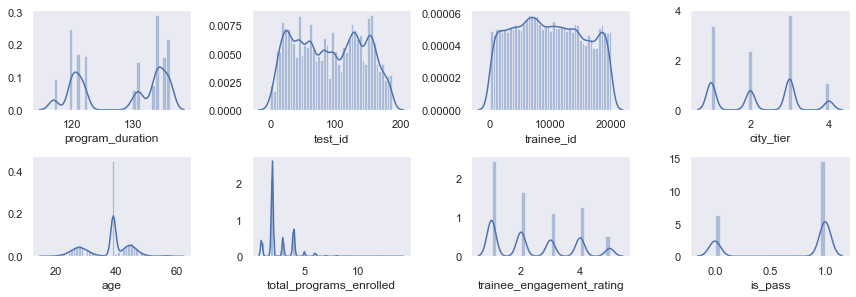

In [21]:
num_attributes = train_df.select_dtypes(exclude='object').copy()
fig = plt.figure(figsize=(12,18))
for i in range(len(num_attributes.columns)):
    fig.add_subplot(9,4,i+1)
    sns.distplot(num_attributes.iloc[:,i].dropna())
    plt.xlabel(num_attributes.columns[i])

plt.tight_layout()
plt.show()

In [22]:
train_df.describe()

,program_duration,test_id,trainee_id,city_tier,age,total_programs_enrolled,trainee_engagement_rating,is_pass
count,73145.000000,73145.000000,73145.000000,73145.000000,73145.000000,73145.000000,73145.000000,73145.000000
mean,128.208668,91.079377,9843.173559,2.246825,37.443311,2.583950,2.395672,0.695413
std,6.889689,51.239391,5703.583442,1.011594,7.226062,1.240819,1.324589,0.460235
min,117.000000,0.000000,1.000000,1.000000,17.000000,1.000000,1.000000,0.000000
25%,121.000000,45.000000,5040.000000,1.000000,30.000000,2.000000,1.000000,0.000000
50%,131.000000,90.000000,9641.000000,2.000000,39.000000,2.000000,2.000000,1.000000
75%,134.000000,135.000000,14552.000000,3.000000,43.000000,3.000000,4.000000,1.000000
max,136.000000,187.000000,20098.000000,4.000000,60.000000,14.000000,5.000000,1.000000


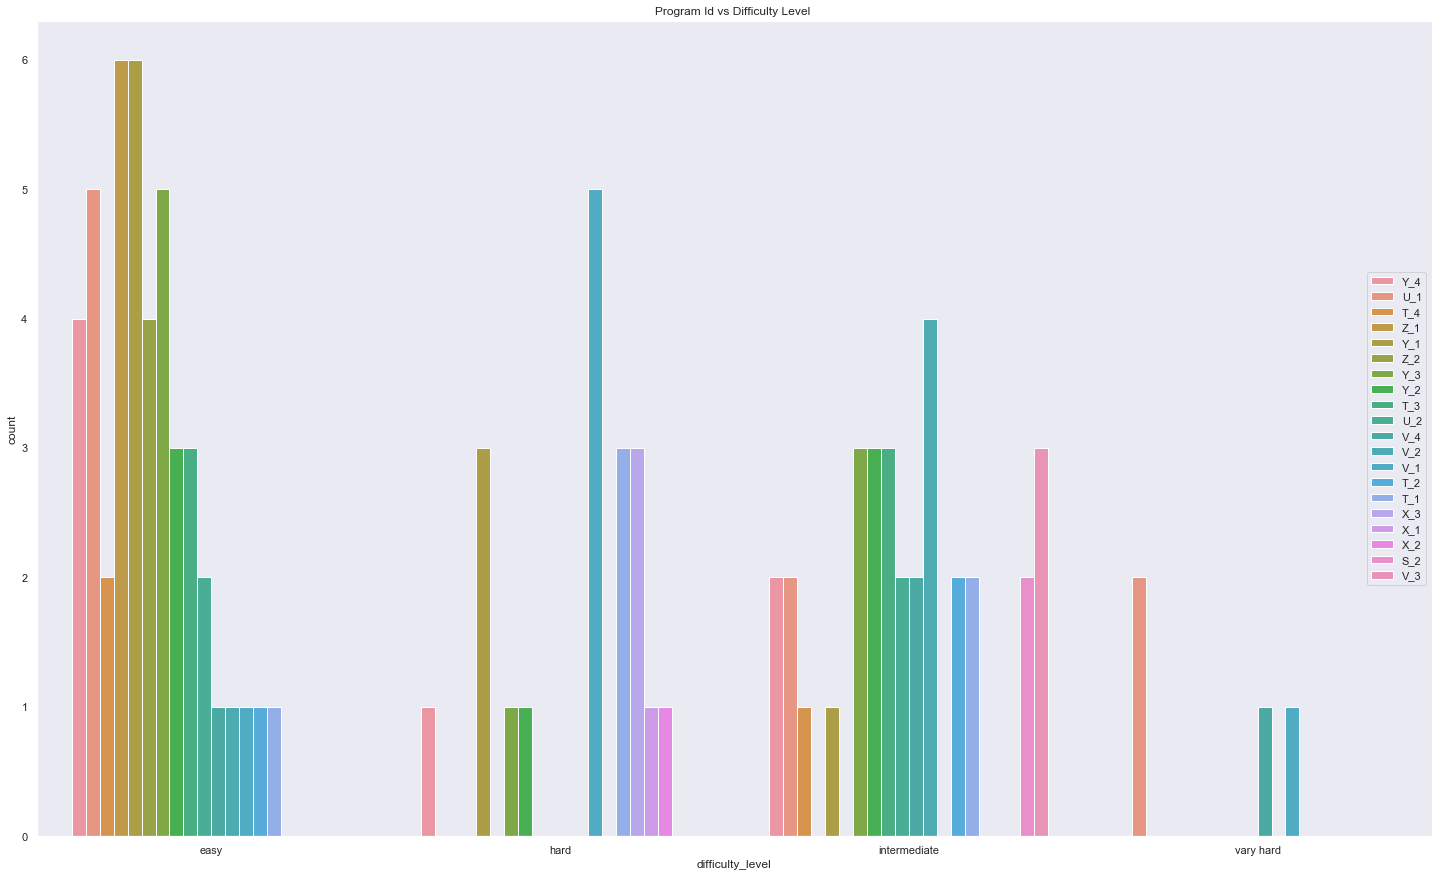

In [23]:
#Visualizations
#plotting a bar chart to identify the programs at each difficulty level 
plt.figure(figsize=(25,15))
plt.title("Program Id vs Difficulty Level ")
sns.countplot('difficulty_level', data = train_df.sample(100).sort_values('difficulty_level'), hue = 'program_id')
plt.legend(loc = 'right')


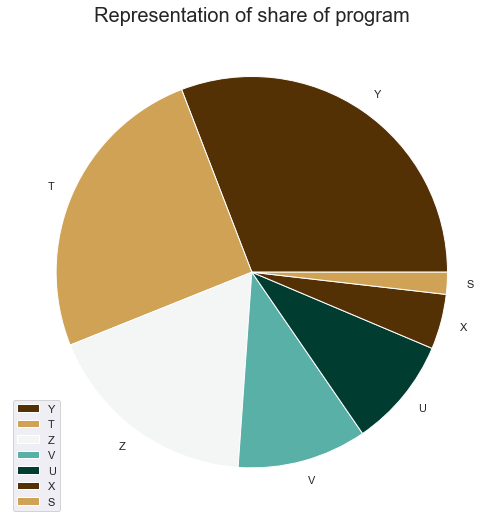

In [24]:
# plotting a pie chart to represent share of program type 
labels = list(train_df['program_type'].unique())
sizes = train_df['program_type'].value_counts()
colors = plt.cm.BrBG(np.linspace(0, 1, 5))
explode = [0.1, 0.1, 0.2, 0.5, 0.9]

plt.rcParams['figure.figsize'] = (9, 9)
plt.pie(sizes, labels = labels, colors = colors)
plt.title('Representation of share of program', fontsize = 20)
plt.legend()
plt.show()


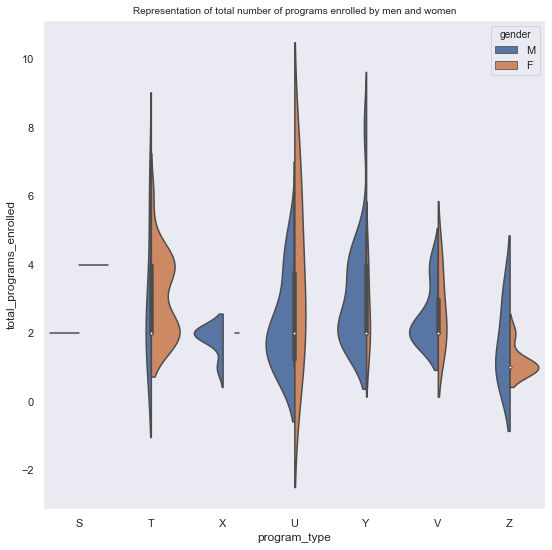

In [25]:
#violin plot to represent the total number of programs enrolled by men and women
plt.title('Representation of total number of programs enrolled by men and women', fontsize = 10)
sns.violinplot(y="total_programs_enrolled", x="program_type", hue="gender",split=True,scale="count",data=train_df.sample(100))

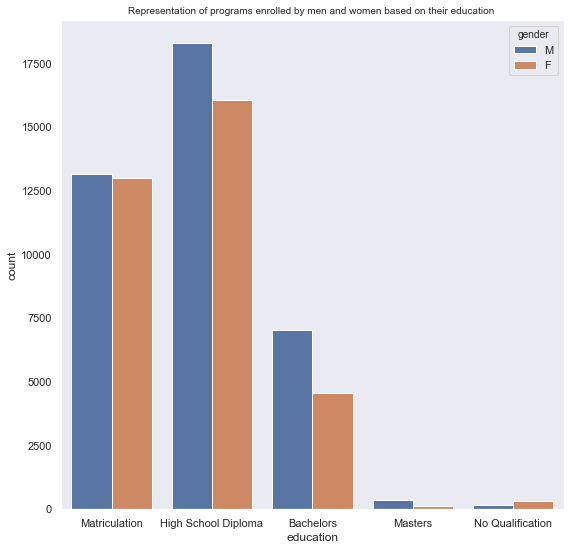

In [26]:
plt.title('Representation of programs enrolled by men and women based on their education ', fontsize = 10)
ax = sns.countplot(x="education", hue="gender",data=train_df)

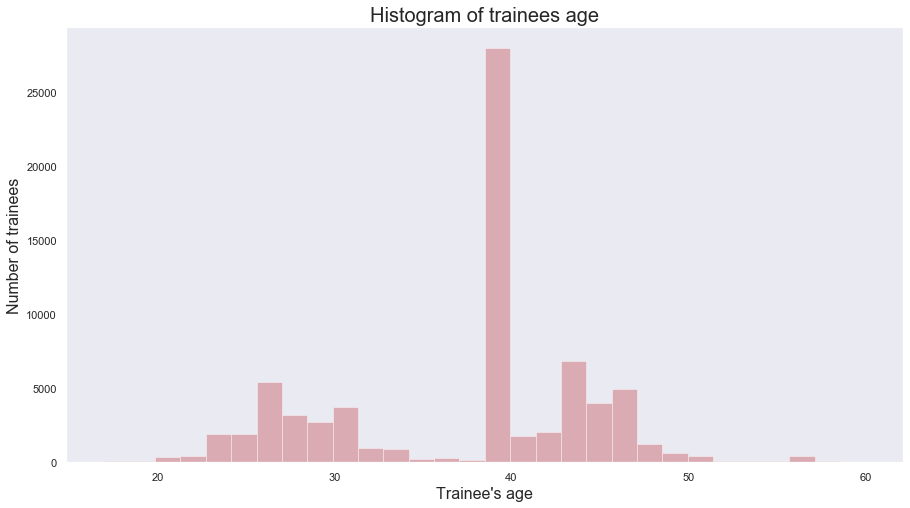

In [27]:
# To show the number of participants in a age group
# Histogram: number of trainee's age

sns.set(style = "dark", palette = "deep", color_codes = True)
x = train_df.age
plt.figure(figsize = (15,8))
ax = sns.distplot(x, bins = 30, kde = False, color = 'r')
ax.set_xlabel(xlabel = "Trainee\'s age", fontsize = 16)
ax.set_ylabel(ylabel = 'Number of trainees', fontsize = 16)
ax.set_title(label = 'Histogram of trainees age', fontsize = 20)
plt.show()

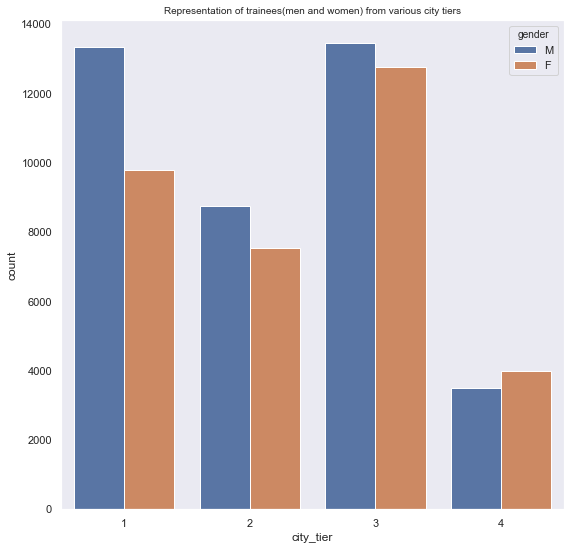

In [28]:
plt.title('Representation of trainees(men and women) from various city tiers', fontsize = 10)
ax = sns.countplot(x="city_tier", hue="gender",data=train_df)

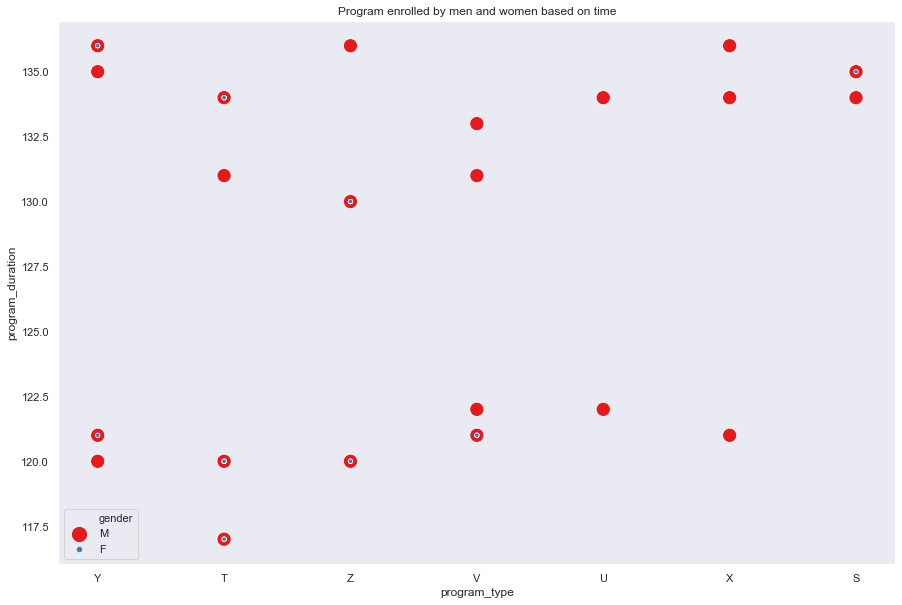

In [29]:
plt.figure(figsize=(15,10))
plt.title("Program enrolled by men and women based on time")
ax = sns.scatterplot(x="program_type",y='program_duration', ci=None,hue="gender",size="gender",sizes=(20, 200),data=train_df,palette="Set1")

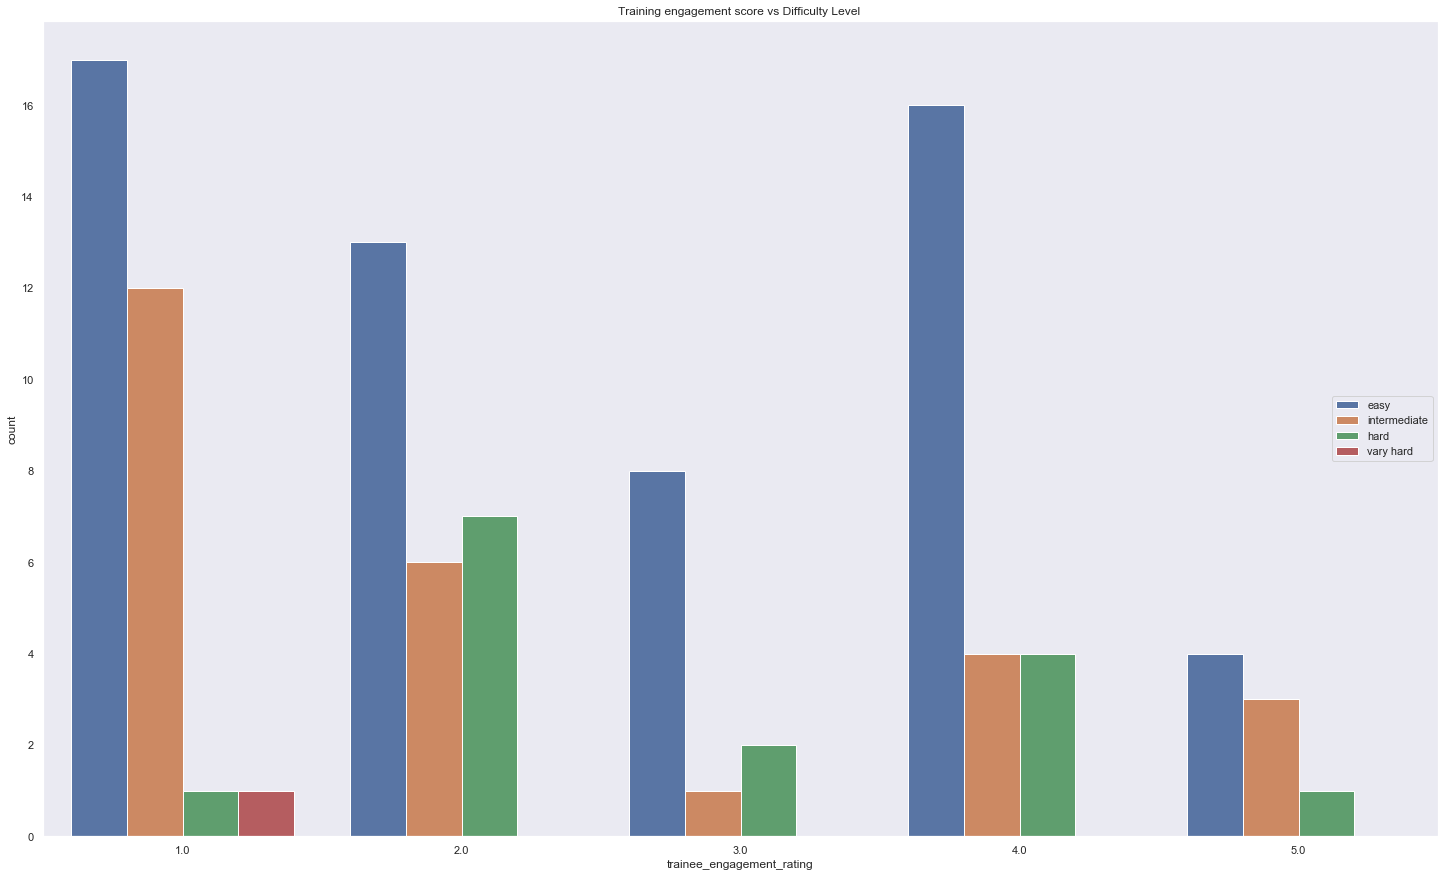

In [30]:
#plotting a bar chart to identify the trainee engagement score at each difficulty level 
plt.figure(figsize=(25,15))
plt.title("Training engagement score vs Difficulty Level ")
sns.countplot('trainee_engagement_rating', data = train_df.sample(100), hue = 'difficulty_level')
plt.legend(loc = 'right')

In [31]:
target=train_df['is_pass']
train_df = train_df.drop(columns = ['id','is_pass'])
test_df = test_df.drop(columns = ['id'])

In [32]:
train_df.head()

,program_id,program_type,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,program_info
0,Y_1,Y,136,150,offline,intermediate,9389,M,Matriculation,3,24.0,5,N,1.0,Y_1_136
1,T_1,T,131,44,offline,easy,16523,F,High School Diploma,4,26.0,2,N,3.0,T_1_131
2,Z_2,Z,120,178,online,easy,13987,M,Matriculation,1,40.0,1,N,2.0,Z_2_120
3,T_2,T,117,32,offline,easy,13158,F,Matriculation,3,39.0,4,N,1.0,T_2_117
4,V_3,V,131,84,offline,intermediate,10591,F,High School Diploma,1,42.0,2,N,4.0,V_3_131


In [33]:

le = LabelEncoder()
train_df['program_info'] = le.fit_transform(train_df['program_info'])
test_df['program_info'] = le.fit_transform(test_df['program_info'])

X_enc = train_df[['difficulty_level','education']].copy()
X_enc = pd.get_dummies(X_enc, columns=['difficulty_level','education'])
train_df = pd.concat([train_df,X_enc], axis=1)

X_enc = test_df[['difficulty_level','education']].copy()
X_enc = pd.get_dummies(X_enc, columns=['difficulty_level','education'])
test_df = pd.concat([test_df,X_enc], axis=1)

train_df.head()

,program_id,program_type,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,...,program_info,difficulty_level_easy,difficulty_level_hard,difficulty_level_intermediate,difficulty_level_vary hard,education_Bachelors,education_High School Diploma,education_Masters,education_Matriculation,education_No Qualification
0,Y_1,Y,136,150,offline,intermediate,9389,M,Matriculation,3,...,15,0,0,1,0,0,0,0,1,0
1,T_1,T,131,44,offline,easy,16523,F,High School Diploma,4,...,2,1,0,0,0,0,1,0,0,0
2,Z_2,Z,120,178,online,easy,13987,M,Matriculation,1,...,20,1,0,0,0,0,0,0,1,0
3,T_2,T,117,32,offline,easy,13158,F,Matriculation,3,...,3,1,0,0,0,0,0,0,1,0
4,V_3,V,131,84,offline,intermediate,10591,F,High School Diploma,1,...,10,0,0,1,0,0,1,0,0,0


In [34]:
train_df = train_df.drop(['program_id','program_type','difficulty_level','education','program_duration'],axis=1)
test_df = test_df.drop(['program_id','program_type','difficulty_level','education','program_duration'],axis=1)

In [35]:
train_df.head()

,test_id,test_type,trainee_id,gender,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,program_info,difficulty_level_easy,difficulty_level_hard,difficulty_level_intermediate,difficulty_level_vary hard,education_Bachelors,education_High School Diploma,education_Masters,education_Matriculation,education_No Qualification
0,150,offline,9389,M,3,24.0,5,N,1.0,15,0,0,1,0,0,0,0,1,0
1,44,offline,16523,F,4,26.0,2,N,3.0,2,1,0,0,0,0,1,0,0,0
2,178,online,13987,M,1,40.0,1,N,2.0,20,1,0,0,0,0,0,0,1,0
3,32,offline,13158,F,3,39.0,4,N,1.0,3,1,0,0,0,0,0,0,1,0
4,84,offline,10591,F,1,42.0,2,N,4.0,10,0,0,1,0,0,1,0,0,0


In [36]:
train_df['gender'] = train_df['gender'].map( {'F': 1, 'M': 0})
test_df['gender'] = test_df['gender'].map( {'F': 1, 'M': 0})

train_df['test_type'] = train_df['test_type'].map( {'online': 1, 'offline': 0})
test_df['test_type'] = test_df['test_type'].map( {'online': 1, 'offline': 0})

train_df['is_handicapped'] = train_df['is_handicapped'].map( {'Y': 1, 'N': 0})
test_df['is_handicapped'] = test_df['is_handicapped'].map( {'Y': 1, 'N': 0})


In [37]:
#train_df=train_df.drop(columns = ['test_id','trainee_id'],axis=1)
#test_df=test_df.drop(columns = ['test_id','trainee_id'],axis=1)

In [38]:
train_df.isna().sum()

test_id                          0
test_type                        0
trainee_id                       0
gender                           0
city_tier                        0
age                              0
total_programs_enrolled          0
is_handicapped                   0
trainee_engagement_rating        0
program_info                     0
difficulty_level_easy            0
difficulty_level_hard            0
difficulty_level_intermediate    0
difficulty_level_vary hard       0
education_Bachelors              0
education_High School Diploma    0
education_Masters                0
education_Matriculation          0
education_No Qualification       0
dtype: int64

In [39]:
train_df = train_df.drop(columns = ['total_programs_enrolled'],axis=1)
test_df = test_df.drop(columns = ['total_programs_enrolled'],axis=1)
train_df.dtypes

test_id                            int64
test_type                          int64
trainee_id                         int64
gender                             int64
city_tier                          int64
age                              float64
is_handicapped                     int64
trainee_engagement_rating        float64
program_info                       int32
difficulty_level_easy              uint8
difficulty_level_hard              uint8
difficulty_level_intermediate      uint8
difficulty_level_vary hard         uint8
education_Bachelors                uint8
education_High School Diploma      uint8
education_Masters                  uint8
education_Matriculation            uint8
education_No Qualification         uint8
dtype: object

In [40]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(train_df, target, train_size=0.70,random_state=1200)

print(train_X.shape, test_X.shape)

(51201, 18) (21944, 18)


In [41]:
train_X.head()

,test_id,test_type,trainee_id,gender,city_tier,age,is_handicapped,trainee_engagement_rating,program_info,difficulty_level_easy,difficulty_level_hard,difficulty_level_intermediate,difficulty_level_vary hard,education_Bachelors,education_High School Diploma,education_Masters,education_Matriculation,education_No Qualification
30671,109,0,17130,0,2,29.0,0,2.0,12,0,0,1,0,0,0,0,1,0
25892,151,0,7002,0,3,39.0,0,4.0,15,0,1,0,0,0,1,0,0,0
31921,119,1,7138,0,3,29.0,0,2.0,18,1,0,0,0,0,1,0,0,0
34534,52,1,5395,0,2,39.0,0,2.0,7,1,0,0,0,0,0,0,1,0
58066,165,1,11298,1,3,20.0,0,1.0,21,1,0,0,0,0,0,0,1,0


In [42]:

test_df.head()


,test_id,test_type,trainee_id,gender,city_tier,age,is_handicapped,trainee_engagement_rating,program_info,difficulty_level_easy,difficulty_level_hard,difficulty_level_intermediate,difficulty_level_vary hard,education_Bachelors,education_High School Diploma,education_Masters,education_Matriculation,education_No Qualification
0,45,0,1626,1,3,46.0,0,4.0,2,0,0,1,0,0,0,0,1,0
1,130,1,11020,0,3,39.0,0,4.0,17,1,0,0,0,1,0,0,0,0
2,146,1,12652,0,3,39.0,0,3.0,16,1,0,0,0,0,0,0,1,0
3,72,0,7038,1,1,39.0,0,2.0,11,0,0,0,1,0,1,0,0,0
4,71,0,888,1,3,39.0,0,2.0,11,0,0,1,0,0,0,0,1,0


In [47]:
#Model building 
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support, roc_auc_score)


xgb_model = xgb.XGBClassifier()

gkf = KFold(n_splits=5, shuffle=True, random_state=412).split(X=train_X, y=train_y)

parameters = {'objective':['binary:logistic'],
              'learning_rate': [0.003], #so called `eta` value
              'max_depth': [4], #5
              'min_child_weight': [1],
              'scale_pos_weight' :[1],
              'subsample': [0.8],
              'colsample_bytree': [0.8],
              'n_estimators': [3000], #number of trees, change it to 1000 for better results
              'seed': [1337]}

clf = GridSearchCV(xgb_model, parameters, n_jobs=5, 
                   cv=gkf, 
                   scoring='roc_auc',
                   verbose=2, refit=True)

clf.fit(X=train_X, y=train_y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 12.8min remaining: 19.3min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 12.9min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 12.9min finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x000001B5D141AEC8>,
             error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weigh...
                                     validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=5,
             param_grid={'colsample_bytree': [0.8], 'learning_rate': [0.06],
                         'max_depth': [5], 'min_child_weight': [1],
                         'n_estimators': [5000],
                         'ob

In [86]:
xgb4 = XGBClassifier(
 learning_rate =0.95,
 n_estimators=5000,
 max_depth=4,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb4.fit(X=train_X, y=train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.95, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=5000, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=27, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=27, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [87]:
xgb4.feature_importances_

array([0.05473976, 0.07637966, 0.05959456, 0.04718858, 0.04825972,
       0.04993894, 0.05022252, 0.06693229, 0.05392094, 0.04918287,
       0.05160004, 0.04619604, 0.07294863, 0.04863341, 0.04677429,
       0.06391768, 0.05725919, 0.05631089], dtype=float32)

In [75]:
test_df.head()

,test_id,test_type,trainee_id,gender,city_tier,age,is_handicapped,trainee_engagement_rating,program_info,difficulty_level_easy,difficulty_level_hard,difficulty_level_intermediate,difficulty_level_vary hard,education_Bachelors,education_High School Diploma,education_Masters,education_Matriculation,education_No Qualification
0,45,0,1626,1,3,46.0,0,4.0,2,0,0,1,0,0,0,0,1,0
1,130,1,11020,0,3,39.0,0,4.0,17,1,0,0,0,1,0,0,0,0
2,146,1,12652,0,3,39.0,0,3.0,16,1,0,0,0,0,0,0,1,0
3,72,0,7038,1,1,39.0,0,2.0,11,0,0,0,1,0,1,0,0,0
4,71,0,888,1,3,39.0,0,2.0,11,0,0,1,0,0,0,0,1,0


In [88]:
x_Pred = xgb4.predict(test_df)


Proportion: 0.4 : 1


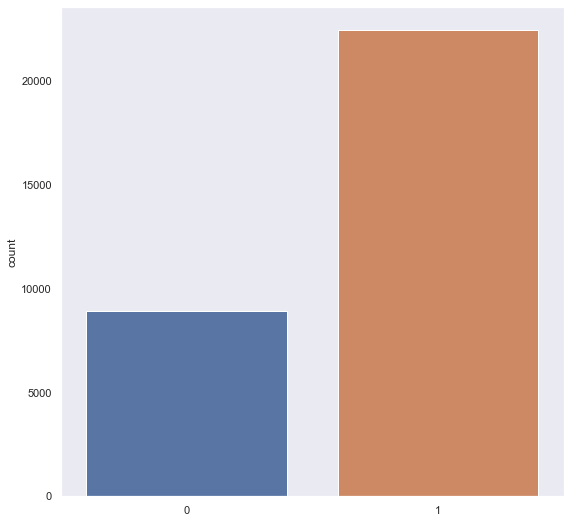

In [89]:
target_count = pd.Series(x_Pred).value_counts()
sns.countplot(x_Pred)
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

In [90]:
output = pd.DataFrame({'id': testf.id,'is_pass': x_Pred})
output.to_csv('predictions_2.csv', index=False)